# 1. Análisis descriptivo de datos

El objetivo de esta unidad es aprender a realizar un análisis exploratorio de datos de distintos tipo, el cálculo de estadísticos de localización y dispersión, histogramas y diagramas de cajas, frecuencias, cálculo de correlaciones así cómo diagramas de dispersión.


In [ ]:
# Si queremos utilizar google colab desde nuestra cuenta de drive es necesario decírselo de la siguiente forma
# Montar Google Dirve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importamos en primer lugar algunas de las librerías que vamos a utilizar.
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from scipy import stats
from statsmodels import robust

# Definir ruta base a tu carpeta de trabajo en Drive
# 👇 cambia esta ruta a la ubicación real de tus datos
DATA = Path("/content/drive/MyDrive/ColabNotebooks/Unit1/data")

## 1.1 Lectura de base de datos

En este curso, vamos a trabajar con bases de datos que, por lo general, suelen venir dadas por ficheros .csv. Por eso, vamos a centrarnos en la lectura de este tipo de ficheros. Utilizaremos la función *pd.read_csv*. *pd* viene de *pandas*, la librería donde se encuentra la función *read_csv*. Esta función necesita como parámetros (*input_file*, *header*, *delimiter*). *Input_file* será el nombre del fichero con su ruta correspondiente. *Header* hace referencia al número de línea que queremos que sea la cabecera, es decir, el nombre de las columnas. *Delimiter* se refiere a cómo vienen separadas las columnas en el fichero (por comas, por punto y coma,...). Existe una función análoga a *read_csv* para leer ficheros .xlsx llamada *read_excel*. En otras prácticas leeremos agún fichero de este tipo y la utilizaremos.

Por ejemplo, una de los archivos que vamos a trabajar en esta práctica es la base de datos state.csv, la cuál contiene las tasas de población y homicidios (en unidades de homicidios por cada 100.000 personas por año) para cada estado de EE. UU. (Censo de 2010). Calcula los estadísticos descriptivos de localización y dispersión que consideres más adecuados para el conjunto de datos. (dataset: state.csv)


In [ ]:
#leemos el archivo con el comando
state = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/state.csv')

state.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


## 1.2 Análisis exploratorio de datos categóricos y binarios.

Para estudiar numéricamente los datos categóricos, es suficiente con la proporción, porcentajes y frecuencias en la que ocurre cada una de las categorías.

El siguiente ejemplo muestra el porcentaje de vuelos canceladas según la causa en el aeropuerto de Dallas / Fort Worth desde 2010- 2019 (dfw_airline.txt)




In [ ]:
dfw = pd.read_csv(
    '/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/dfw_airline.txt',
    sep=r"\s+",        # separador: espacios/tabulaciones
    header=0           # primera fila son nombres de columnas
)

In [ ]:
# tamaño del conjunto de datos. En lugar de print también podemos usar display.
display(dfw.shape)
display(dfw.head())



(5, 2)

,Tipo,Frecuencia
0,Carrier,64263.16
1,ATC,84856.50
2,Weather,11235.42
3,Security,343.15
4,Inbound,118427.82


In [ ]:
# Seleccionamos columnas
tabla = dfw[["Tipo", "Frecuencia"]].copy()

# Frecuencia relativa (porcentaje)
tabla["Frecuencia relativa"] = tabla["Frecuencia"] / tabla["Frecuencia"].sum()

print(tabla)

       Tipo  Frecuencia  Frecuencia relativa
0   Carrier    64263.16             0.230230
1       ATC    84856.50             0.304008
2   Weather    11235.42             0.040252
3  Security      343.15             0.001229
4   Inbound   118427.82             0.424281


In [ ]:
# Asegura que la columna es numérica (por si viniera como texto)
dfw["Frecuencia"] = pd.to_numeric(dfw["Frecuencia"], errors="coerce")

# Total y tabla con relativas
total = dfw["Frecuencia"].sum()
tabla = (
    dfw[["Tipo", "Frecuencia"]]
    .rename(columns={"Frecuencia": "Frecuencia_absoluta"})
    .assign(Frecuencia_relativa=lambda d: d["Frecuencia_absoluta"] / total)
    .sort_values("Frecuencia_absoluta", ascending=False)
    .reset_index(drop=True)
)

# Acumuladas (opcional, útiles para análisis)
tabla["Acumulada_abs"] = tabla["Frecuencia_absoluta"].cumsum()
tabla["Acumulada_rel"] = tabla["Frecuencia_relativa"].cumsum()

# Versión bonita para ver en pantalla (porcentajes al 2º decimal)
tabla_mostrar = tabla.copy()
tabla_mostrar["Frecuencia_relativa"] = (tabla_mostrar["Frecuencia_relativa"]*100).round(2)
tabla_mostrar["Acumulada_rel"] = (tabla_mostrar["Acumulada_rel"]*100).round(2)
tabla_mostrar

,Tipo,Frecuencia_absoluta,Frecuencia_relativa,Acumulada_abs,Acumulada_rel
0,Inbound,118427.82,42.43,118427.82,42.43
1,ATC,84856.50,30.40,203284.32,72.83
2,Carrier,64263.16,23.02,267547.48,95.85
3,Weather,11235.42,4.03,278782.90,99.88
4,Security,343.15,0.12,279126.05,100.00


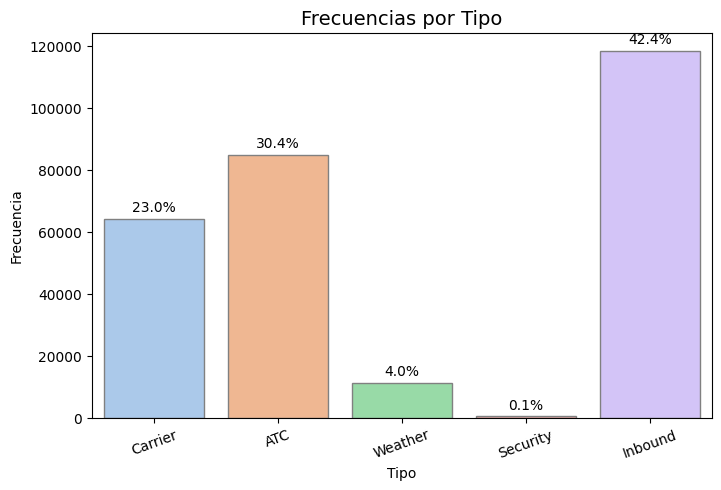

In [ ]:
# Crear gráfico de barras con seaborn
plt.figure(figsize=(8,5))
ax = sns.barplot(data=dfw, x="Tipo", y="Frecuencia", hue="Tipo", dodge=False, palette="pastel", edgecolor="grey")

# Añadir etiquetas encima de cada barra
total = dfw["Frecuencia"].sum()
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    ax.annotate(
        percentage,            # formato con separador de miles, sin decimales
        (p.get_x() + p.get_width() / 2., p.get_height()),  # posición en la barra
        ha='center', va='bottom', fontsize=10, color='black', xytext=(0,3), textcoords='offset points'
    )


# Personalizar
plt.title("Frecuencias por Tipo", fontsize=14)
plt.xlabel("Tipo")
plt.ylabel("Frecuencia")
plt.xticks(rotation=20)

# Mostrar
plt.show()

Si tenemos una variable y queremos reordenar los niveles según algún criterio, podemus utilizar la función *sort*



Categorías (orden alfabético): Index(['ATC', 'Carrier', 'Inbound', 'Security', 'Weather'], dtype='object')
       Tipo  Frecuencia
0   Carrier    64263.16
1       ATC    84856.50
2   Weather    11235.42
3  Security      343.15
4   Inbound   118427.82

Ordenado por Tipo (alfabético):
       Tipo  Frecuencia
0       ATC    84856.50
1   Carrier    64263.16
2   Inbound   118427.82
3  Security      343.15
4   Weather    11235.42


<Axes: xlabel='Tipo', ylabel='Frecuencia'>

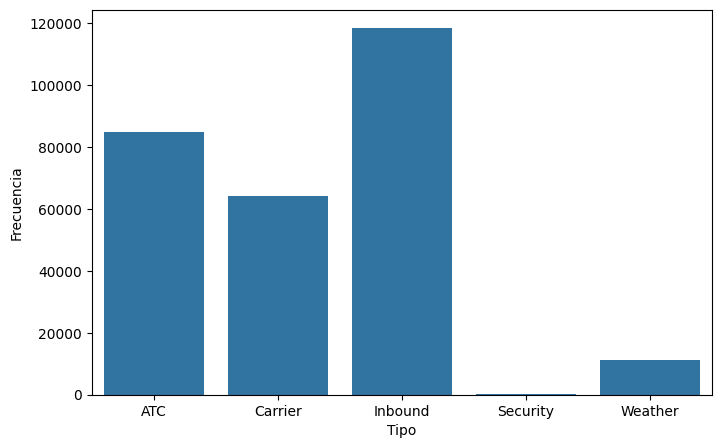

In [ ]:
# Crear categorías ordenadas alfabéticamente
dfw["Tipo"] = pd.Categorical(dfw["Tipo"], categories=sorted(dfw["Tipo"].unique()), ordered=True)
#ahora dfw['Tipo'] tiene categorías con el orden 'ATC', 'Carrier', 'Inbound', 'Security', 'Weather'
print("\nCategorías (orden alfabético):", dfw["Tipo"].cat.categories)
print(dfw)

#Reordenar el DataFrame por Tipo
dfw_sorted = dfw.sort_values("Tipo").reset_index(drop=True)
print("\nOrdenado por Tipo (alfabético):")
print(dfw_sorted)

# Crear gráfico de barras con seaborn
plt.figure(figsize=(8,5))
sns.barplot(data=dfw, x="Tipo", y="Frecuencia")


## 1.3 Análisis exploratorio de datos cuantitativos

A partir de la base de datos state.csv, la cuál contiene las  tasas de población y homicidios (en unidades de homicidios por cada 100.000 personas por año) para cada estado de EE. UU. (Censo de 2010). Calcula los estadísticos descriptivos de localización y dispersión que consideres más adecuados para el conjunto de datos. (dataset: state.csv)

###1.3.1 Estimaciones de localización

Las variables con datos de medición o recuento pueden tener miles de valores diferentes. Un paso fundamental para explorar los datos es definir un "valor típico" para cada variable: una estimación de dónde se ubica la mayor parte de los datos (tendencia central).

Promedio: Sensible a valores extremos (valores atípicos). Alternativa: media recortada.
Mediana: Estimación robusta de la ubicación, ya que no se ve afectada por valores atípicos que puedan revertir los resultados.



En primer lugar, calcularemos la media, mediana y media recortada de la población.



In [ ]:
state = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/state.csv')

In [ ]:
# tamaño de conjunto de datos
display(state.shape)
# principales estadísticos descriptivos del conjunto de datos
display(state.describe())
#conocer si existen NaN en el conjunto de datos y cuantos hay.
display(state.isna().sum())

#eliminar las filas en las que hay NaN
#state = state.dropna()

(50, 4)

,Population,Murder.Rate
count,5.000000e+01,50.000000
mean,6.162876e+06,4.066000
std,6.848235e+06,1.915736
min,5.636260e+05,0.900000
25%,1.833004e+06,2.425000
50%,4.436370e+06,4.000000
75%,6.680312e+06,5.550000
max,3.725396e+07,10.300000


,0
State,0
Population,0
Murder.Rate,0
Abbreviation,0


In [ ]:
state.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


In [ ]:
# mean
print(state['Population'].mean())

6162876.3


In [ ]:
# trimmed mean
stats.trim_mean(state['Population'], 0.1)

np.float64(4783697.125)

In [ ]:
# median
state['Population'].median()

4436369.5

 La media es mayor que la media recortada, que también es mayor que la mediana.

Otras medidas de localización son la media ponderada. Calcularemos esta media ponderada para el caso de la tasa de homicidio para el país.


In [ ]:
# weighted average
np.average(state["Murder.Rate"], weights=state["Population"])

np.float64(4.445833981123393)

In [ ]:
# weighted median
state.sort_values('Murder.Rate', inplace=True)
cumsum = state.Population.cumsum()
cutoff = state.Population.sum() / 2.0
median_weight = state['Murder.Rate'][cumsum >= cutoff].iloc[0]
median_weight

np.float64(4.4)

La métrica básica para la localización es el promedio, pero este puede ser sensible a valores atípicos. Otras métricas (mediana, media recortada) son más robustas.

### 1.3.2 Estadísticos de dispersión

La localización es solo una dimensión para resumir una característica. Una segunda dimensión, la variabilidad, también llamada dispersión, mide si los valores de los datos están comprimidos o dispersos.

Desviaciones: Diferencia entre los valores observados y la estimación de la media.
Varianza: Suma de los cuadrados de las desviaciones con respecto a la media, dividida entre n-1.
Desviación estándar: Raíz cuadrada de la varianza.
Percentil/Cuantil: Valor del cual el P por ciento de los valores es este valor o menos, y el (100-P) por ciento es este valor o más.
Rango intercuátil (RIC): Diferencia entre el percentil 75 y el percentil 25.

La varianza y la desviación estándar son especialmente sensibles a los valores atípicos, ya que se basan en desviaciones cuadráticas.
Una estimación de la variabilidad robusta es la desviación absoluta mediana con respecto a la mediana (MAD, mean absolute desviation). Al igual que la mediana, la DAM no se ve afectada por los valores extremos

Calcularemos ahora medidas de estadísticos de dispersión como la desviación estándar

In [ ]:
# standard deviation
state['Population'].std()

6848235.347401144

In [ ]:
# Interquatile range (IQR)
q1 = state['Population'].quantile(0.25)
q3 = state['Population'].quantile(0.75)
iqr = q3-q1
iqr

np.float64(4847308.0)

In [ ]:
# median absolute desviation MAD
robust.mad(state['Population'])

np.float64(3849876.1459979336)

### 1.3.3 Explorando la Distribución de Datos

Cada estimación muestra los datos en un solo número para describir su ubicación y variabilidad.

Diagrama de Caja: Gráfico para visualizar rápidamente la distribución de los datos.
Tabla de Frecuencias: Recuento de valores numéricos de los datos que se encuentran en un conjunto de intervalos.
Histograma: Gráfico de la tabla de frecuencias con las columnas en el eje x y el recuento en el eje y.
Gráfico de Densidad: Simplificación del histograma. Se utiliza frecuentemente en estimaciones de densidad Kernel.

Calcular los percentiles de la tasa de homicidios y visualizar la distribución de los datos de población mediante un diagrama de caja.

In [ ]:
# homicide rate percentiles
q_5 = round(state['Murder.Rate'].quantile(0.05),2)
q_25 = round(state['Murder.Rate'].quantile(0.25),2)
q_50 = round(state['Murder.Rate'].quantile(0.50),2)
q_75 = round(state['Murder.Rate'].quantile(0.75),2)
q_95 = round(state['Murder.Rate'].quantile(0.95),2)
print(f'5% {q_5} - 25% {q_25} - 50% {q_50} - 75% {q_75} - 95% {q_95}')

5% 1.6 - 25% 2.42 - 50% 4.0 - 75% 5.55 - 95% 6.51


The median is 4 homicides per 100 thousand people, but there is variability: the 5º percentile is only 1.6, and the 95º percentile is 6.51.

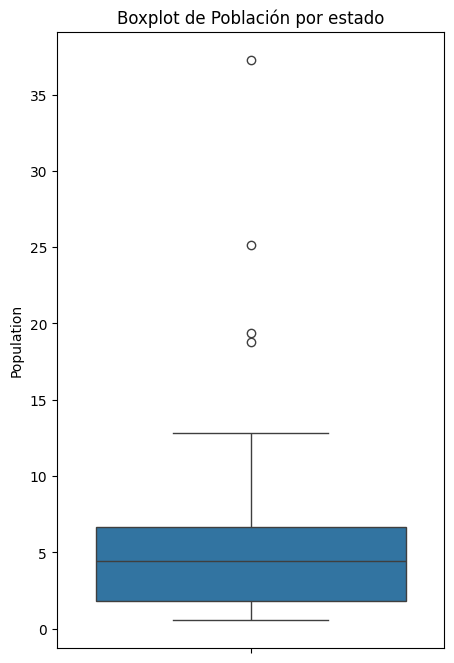

In [ ]:
# population data distribution by boxplot
plt.figure(figsize=(5,8))
sns.boxplot(y=state['Population']/1000000)
plt.title("Boxplot de Población por estado")
plt.show()

Las partes inferior y superior del cuadro representan los percentiles 75 y 25. La mediana se muestra en la línea horizontal.
Las líneas que se extienden de arriba a abajo indican la variación de la masa de datos y se denominan wiskers (1,5 o 3,0 * RIQ).
Los puntos únicos fuera de los wiskers son los valores atípicos.

In [ ]:
# show outliers
state.sort_values(by='Population', ascending=False).head(4)

,State,Population,Murder.Rate,Abbreviation
4,California,37253956,4.4,CA
42,Texas,25145561,4.4,TX
31,New York,19378102,3.1,NY
8,Florida,18801310,5.8,FL


Mostrar frecuencias de población por estado en histogramas

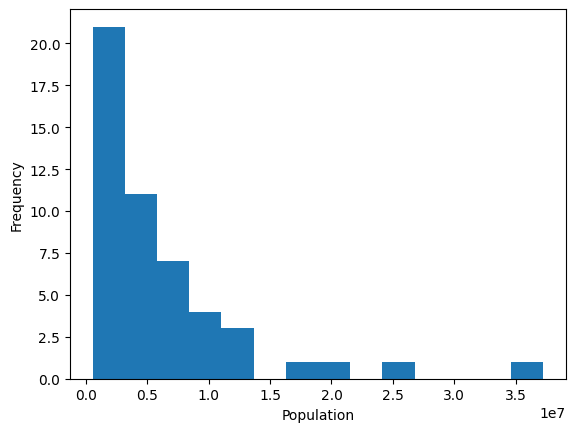

In [ ]:
# histogram
plt.hist(state['Population'], bins='auto')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

Columnas en el eje x y recuento de datos en el eje y

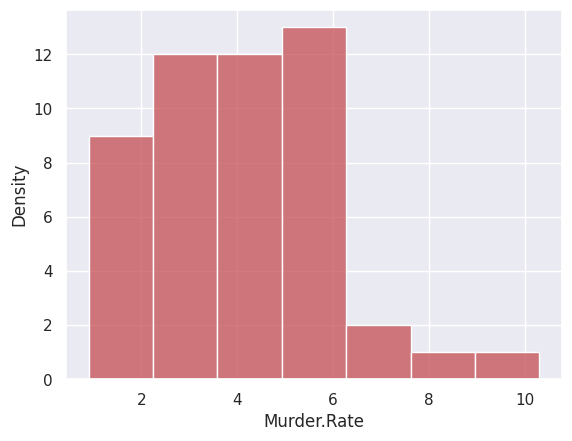

In [ ]:
sns.set()
sns.histplot(state['Murder.Rate'], color='r')
plt.ylabel('Density')
plt.show()

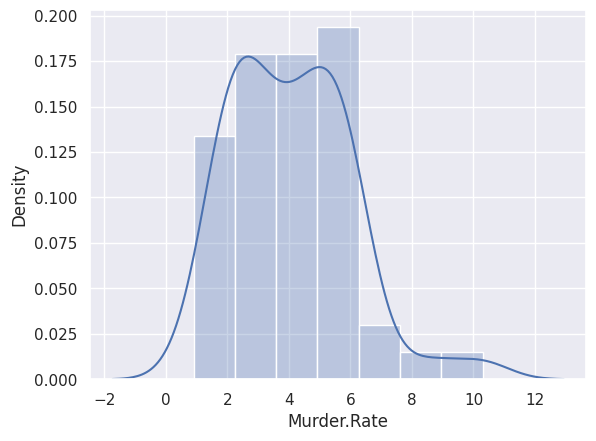

In [ ]:
sns.histplot(
    state['Murder.Rate'], kde=True,
    stat='density',
    fill=True,  # fill activa la sombra de las barras
    kde_kws={"cut": 3},
    alpha=0.3 #transparencia
)
plt.show()

Este gráfico es una versión suavizada del histograma. El eje y muestra una estimación de la frecuencia relativa de cada valor.

En términos probabilísticos, es una estimación de la función de densidad de probabilidad de la característica.

Ideas clave:
El histograma de frecuencia registra los conteos de frecuencia en el eje y y los valores de las variables en el eje x.
El diagrama de caja ofrece una idea rápida de la distribución de los datos. Se suele utilizar en visualizaciones en paralelo.

## 1.4 Análisis exploratorio de dos o más variables.

### 1.4.1 Correlación

Estudio de la correlación entre dos variables.
Las variables X e Y se consideran positivamente correlacionadas si los valores altos de X siguen a los valores altos de Y, y los valores bajos de X siguen a los valores bajos de Y.
Si los valores altos de X acompañan a los valores bajos de Y, y viceversa, las variables están negativamente correlacionadas.

Coeficiente de correlación: Métrica que mide el grado de asociación entre las variables numéricas (rango de -1 a +1).
El *coeficiente de correlación* nos mide la correlación entre dos variables, es una medida adimensional entre $-1$ y $1$:
$r=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_{i}-\bar{y})}{(n-1)s_{x}s_{y}}$


Matriz de correlación: Tabla en la que las variables se muestran tanto en filas como en columnas, y los valores de las celdas representan la correlación entre ellas.
Diagrama de dispersión: Gráfico en el que el eje x representa el valor de una variable y el eje y el valor de otra. Cada punto del gráfico es un registro. Forma estándar de visualizar la relación entre dos variables.

El siguiente conjunto de datos corresponde a los rendimientos diarios de acciones del sector de telecomunicaciones en el período comprendido entre enero 1993 y junio de 2015 (Dataset: sp500). Incluye a varias compañías representativas del sector. Este conjunto permite analizar la dinámica conjunta de los títulos y estudiar el grado de correlación entre ellos, proporcionando información relevante para el análisis financiero y la gestión de carteras.

Mostramos la matriz de correlación de los rendimientos diarios de los fondos indexados más grandes

In [ ]:
# loading news datasets for this analysis
sp500_px = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/sp500_data.csv.gz')
sp500_sym = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/sp500_sectors.csv')

In [ ]:
sp500_px.head()

,DATA,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,...,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
0,1993-01-29,0.0,0.060124,-0.022100,0.0,0.0,0.018897,0.007368,0.092165,0.259140,...,0.0,0.0,0.34716,0.0,0.04167,0.00000,0.015564,1.75,0.1250,0.0
1,1993-02-01,0.0,-0.180389,0.027621,0.0,0.0,0.018889,0.018425,0.115207,-0.100775,...,0.0,0.0,-0.23144,0.0,0.00000,-0.01041,0.007782,1.25,0.1250,0.0
2,1993-02-02,0.0,-0.120257,0.035900,0.0,0.0,-0.075573,0.029482,-0.023041,0.028796,...,0.0,0.0,-0.11572,0.0,0.00000,0.00000,-0.007792,-0.25,0.0000,0.0
3,1993-02-03,0.0,0.060124,-0.024857,0.0,0.0,-0.151128,0.003689,-0.253454,-0.043190,...,0.0,0.0,-0.08679,0.0,0.04167,-0.04167,-0.038919,-0.50,0.0625,0.0
4,1993-02-04,0.0,-0.360770,-0.060757,0.0,0.0,0.113350,-0.022114,0.069862,0.000000,...,0.0,0.0,0.14465,0.0,-0.04166,-0.03126,-0.046711,0.00,0.0625,0.0


In [ ]:
sp500_sym.head()

,sector,sector_label,sub_sector,symbol
0,information_technology,Technology,data_processing_&_outsourced_services,ADS
1,information_technology,Technology,systems_software,CA
2,information_technology,Technology,systems_software,MSFT
3,information_technology,Technology,systems_software,RHT
4,information_technology,Technology,it_consulting_&_services,CTSH


In [ ]:
#El DataFrame sp500_px tenía una columna sin nombre claro (Unnamed: 0) que contenía las fechas.
#con rename, la renombramos a "DATA". Ahora sp500_px["DATA"] es la columna de fechas.

sp500_px = sp500_px.rename(columns={'Unnamed: 0': 'DATA'})

#Filtrado de filas, selecciona solo las filas posteriores al 1 de julio de 2012
#sp500_px['DATA'] > "2012-07-01" selecciona solo las filas posteriores al 1 de julio de 2012.

#Es decir, se quedan los rendimientos diarios desde esa fecha en adelante.

#Selección de columnas
#sp500_sym[sp500_sym['sector'] == 'etf']['symbol'] toma el DataFrame sp500_sym (que debe contener información de los símbolos y sectores).
#Filtra solo aquellos cuyo sector == 'etf'. ETF Exchange-Traded Fund (fondo cotizado en bolsa).
#Devuelve la lista de sus símbolos (tickers).
#Eso se usa como lista de nombres de columnas para sp500_px.

#Resultado
#etfs será un DataFrame con:
#Filas = observaciones después de julio 2012.
#Columnas = solo los símbolos correspondientes a los ETF dentro del S&P500.

etfs = sp500_px.loc[sp500_px['DATA'] > "2012-07-01",
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]

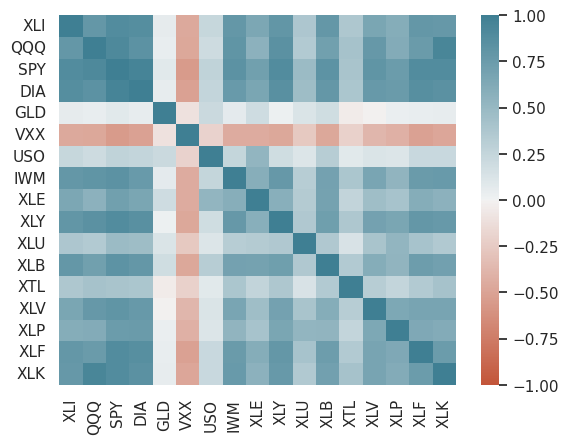

In [ ]:
sns.heatmap(etfs.corr(), vmin=-1, vmax=1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True))
plt.show()


Los ETF SPY y DIA tienen una alta correlación. Al igual que QQQ y XLK.

Dibujamos el diagrama de dispersión para visualizar la relación entre dos variables

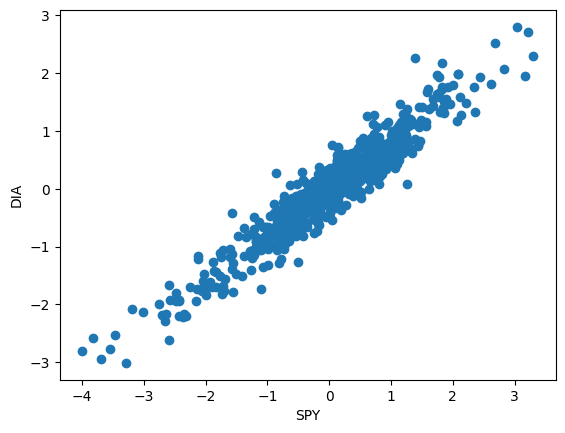

In [ ]:
# positively correlated
plt.xlabel('SPY')
plt.ylabel('DIA')
plt.scatter(etfs['SPY'], etfs['DIA'])
plt.show()

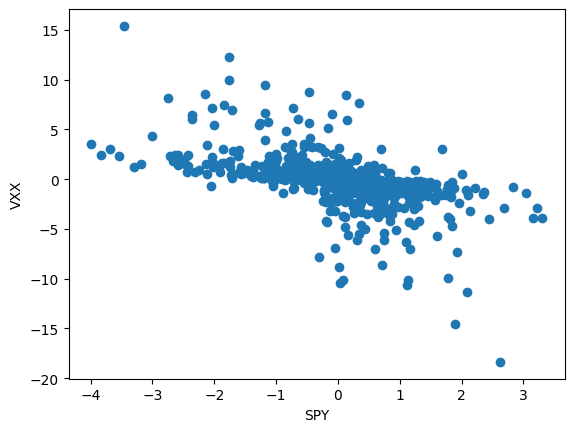

In [ ]:
# negatively correlated
plt.xlabel('SPY')
plt.ylabel('VXX')
plt.scatter(etfs['SPY'], etfs['VXX'])
plt.show()

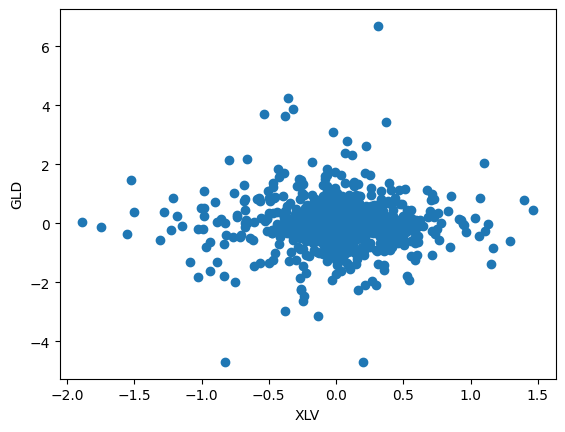

In [ ]:
# no correlation
plt.xlabel('XLV')
plt.ylabel('GLD')
plt.scatter(etfs['XLV'], etfs['GLD'])
plt.show()

El coeficiente de correlación siempre está entre +1 (correlación perfectamente positiva) y -1 (correlación perfectamente negativa). Un valor cercano a 0 indica que no hay correlación.
Las variables pueden tener una asociación no lineal, en cuyo caso el coeficiente de correlación podría no ser una métrica útil.

### 1.4.2 Gráficos que muestran la relación entre dos o más variables


- *scatterplot* (Nube de puntos),

- *Hexagonal binning plot*, las gráficas *scatterplot* están bien cuando hay un número relativamente pequeño de datos. Cuando hay muchos datos los *scatterplots* no tienen sentido porque son demasiado densas. En el Hexagonal binning en lugar de pintar puntos, se agrupan las observaciones en contenedores hezagonales y se pintan los hexágonos en un color indicando el número de observaciones en cada contenedor.

En el gráfico se ve clara la relación entre la dimensión y la tasa de impuestos. Una interesante característica escondida, es la segunda nube arriba de la primera nube más marcada, indicando las residencias con la misma dimensión pero con una tasa de impuestos mayor. Característica que se ve más claramente en el siguiente gráfico.

- *Contour plot* (diagrama de puntos con curvas de nivel), figura que muestra la densidad de dos variables numéricas como en un mapa topográfico. Mismas conclusiones que en el hexagonal binninb, se ve más claramente el segundo pico.

- *Violin plots*, similar al boxplot pero mostrando la estimación de la densidad, en el que se pueden apreciar matices no apreciables en el boxplot. Para combinar un violin plot con un boxplot añadir *geom-boxplot* al gráfico.

Los siguientes datos muestran la tasa de impuestos, dimensión y códigos zip de 432,693 propiedades residenciales de King County,
Washington.

#### Hexagonal bining plot para valores fiscales versus metro cuadrado terminado

In [ ]:
kc_tax = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/kc_tax.csv.gz')
kc_tax.head()

,TaxAssessedValue,SqFtTotLiving,ZipCode
0,NaN,1730,98117.0
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0


In [ ]:
# Removing very expensive and very small or large residences
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) &
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
kc_tax0.shape

(432693, 3)

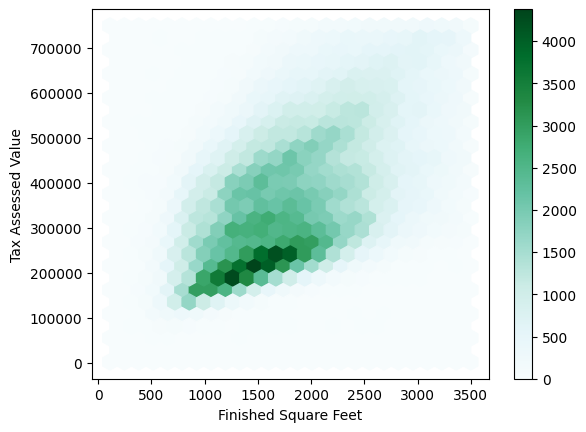

<Figure size 2200x1000 with 0 Axes>

In [ ]:
kc_tax0.plot(kind='hexbin', x='SqFtTotLiving', y='TaxAssessedValue', sharex=False, gridsize=25)
plt.xlabel('Finished Square Feet')
plt.ylabel('Tax Assessed Value')
plt.figure(figsize=(22,10))
plt.show()

Los gráficos de dispersión son útiles cuando la cantidad de datos es relativamente pequeña. Para conjuntos de datos con cientos de miles o millones de registros, este gráfico sería muy denso. En el gráfico hexagonal, los registros se agrupan en compartimentos hexagonales con un color que indica la cantidad de registros en cada compartimento.

Los gráficos se pueden ampliar a más variables. El importe del impuesto es mayor para algunos códigos postales.

In [ ]:
kc_tax_zip1 = kc_tax0.loc[(kc_tax0.ZipCode == 98188), :]
kc_tax_zip2 = kc_tax0.loc[(kc_tax0.ZipCode == 98105), :]
kc_tax_zip3 = kc_tax0.loc[(kc_tax0.ZipCode == 98108), :]
kc_tax_zip4 = kc_tax0.loc[(kc_tax0.ZipCode == 98126), :]

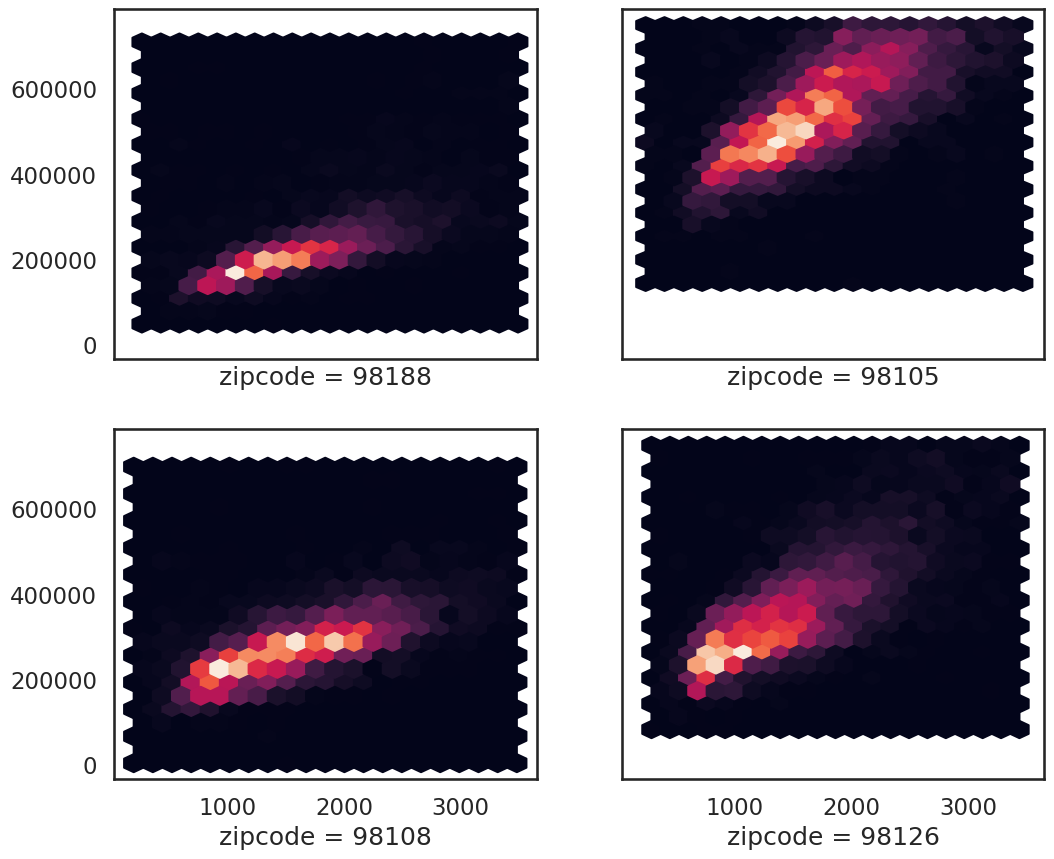

In [ ]:
sns.set_style('white')
sns.set_palette('Greens') # Changed 'g' to 'Greens'
sns.set_context('talk')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))
ax1.hexbin(kc_tax_zip1.SqFtTotLiving, kc_tax_zip1.TaxAssessedValue, gridsize=20)
ax1.set_xlabel('zipcode = 98188')

ax2.hexbin(kc_tax_zip2.SqFtTotLiving, kc_tax_zip2.TaxAssessedValue, gridsize=20)
ax2.set_xlabel('zipcode = 98105')

ax3.hexbin(kc_tax_zip3.SqFtTotLiving, kc_tax_zip3.TaxAssessedValue, gridsize=20)
ax3.set_xlabel('zipcode = 98108')

ax4.hexbin(kc_tax_zip4.SqFtTotLiving, kc_tax_zip4.TaxAssessedValue, gridsize=20)
ax4.set_xlabel('zipcode = 98126')

plt.show()

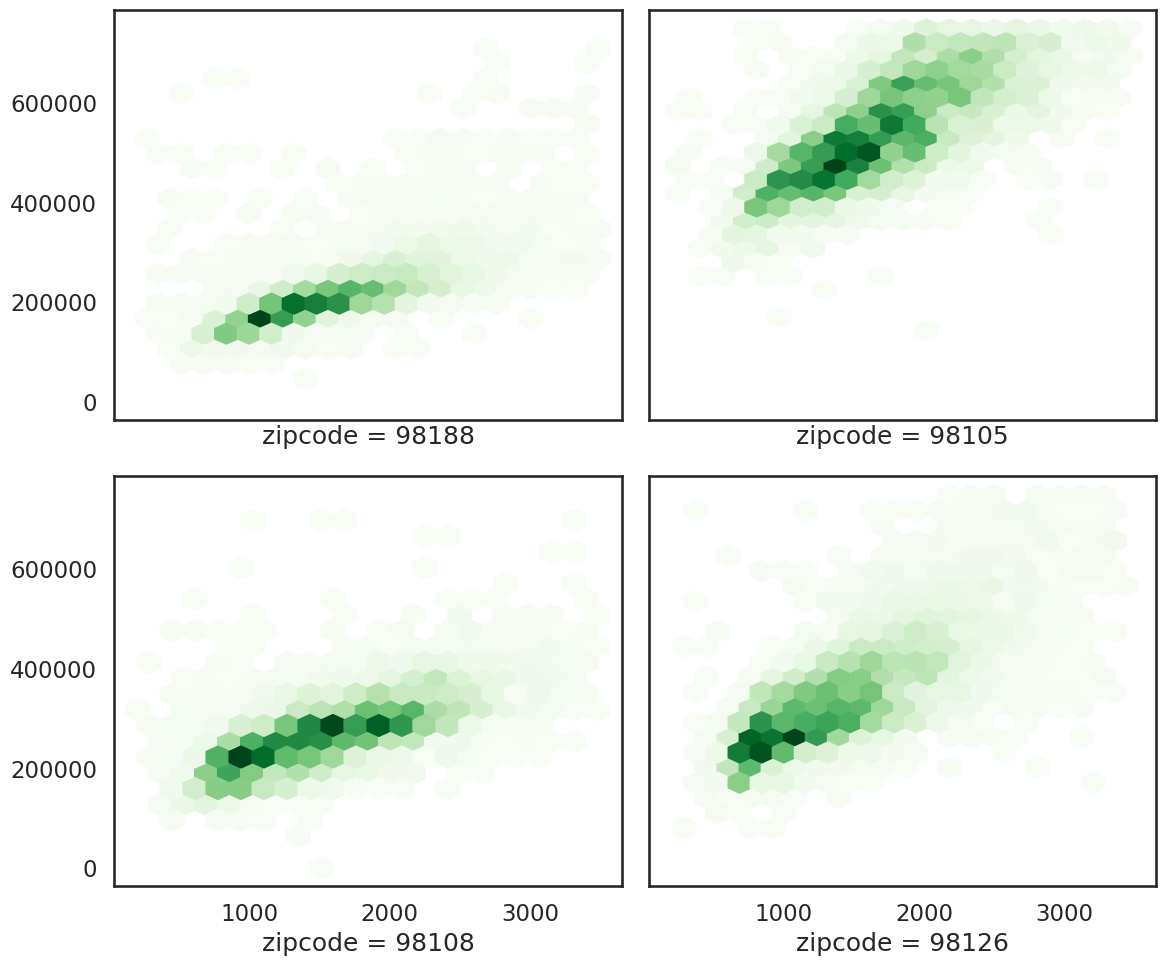

In [ ]:
#para que se vea si no hay dayos en blanco
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set_context('talk')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))

# Paleta clara: "Greens"
cmap = plt.cm.Greens

ax1.hexbin(kc_tax_zip1.SqFtTotLiving, kc_tax_zip1.TaxAssessedValue,
           gridsize=20, cmap=cmap, mincnt=1)
ax1.set_xlabel('zipcode = 98188')

ax2.hexbin(kc_tax_zip2.SqFtTotLiving, kc_tax_zip2.TaxAssessedValue,
           gridsize=20, cmap=cmap, mincnt=1)
ax2.set_xlabel('zipcode = 98105')

ax3.hexbin(kc_tax_zip3.SqFtTotLiving, kc_tax_zip3.TaxAssessedValue,
           gridsize=20, cmap=cmap, mincnt=1)
ax3.set_xlabel('zipcode = 98108')

ax4.hexbin(kc_tax_zip4.SqFtTotLiving, kc_tax_zip4.TaxAssessedValue,
           gridsize=20, cmap=cmap, mincnt=1)
ax4.set_xlabel('zipcode = 98126')

plt.tight_layout()
plt.show()


La imagen muestra que el importe del impuesto es mayor en el código postal 98105 que en el 98108, por ejemplo.

### 1.4.3 Tablas de contingencia para dos variables categóricas.

Para ello usaremos el conjunto de datos que contiene los datos de préstamos de una determinada institución (dataset: lc_loans.csv). Este conjunto de datos representa miles de préstamos otorgados a través de la plataforma Lending Club, que permite prestar dinero entre particulares.


Una forma sencilla de resumir dos variables categóricas es la tabla de contingencia

In [ ]:
lc_loans = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/lc_loans.csv')
lc_loans.head()

,status,grade
0,Fully Paid,B
1,Charged Off,C
2,Fully Paid,C
3,Fully Paid,C
4,Current,B


In [ ]:
x_tab = pd.crosstab(lc_loans.grade, lc_loans.status)
x_tab['Total'] = pd.crosstab(lc_loans.grade, lc_loans.status).apply(lambda r: r.sum(), axis=1)
x_tab

status,Charged Off,Current,Fully Paid,Late,Total
grade,,,,,
A,1562,50051,20408,469,72490
B,5302,93852,31160,2056,132370
C,6023,88928,23147,2777,120875
D,5007,53281,13681,2308,74277
E,2842,24639,5949,1374,34804
F,1526,8444,2328,606,12904
G,409,1990,643,199,3241


### 1.4.4 Diagramas de caja para datos categóricos y numéricos

Una forma sencilla de comparar visualmente las distribuciones de una variable numérica agrupada según una variable categórica.
Por ejemplo, comparar cómo varía el porcentaje de retrasos en vuelos entre aerolíneas (dataset: airline_stats.csv).

In [ ]:
airline_stats= pd.read_csv('/content/drive/MyDrive/ColabNotebooks/StatsPython/Unit1/data/airline_stats.csv')
airline_stats.sample(5)

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
18022,5.924347,4.937414,0.508941,Jet Blue
17085,6.636364,7.909091,2.284091,Jet Blue
31639,6.417178,3.226994,1.392638,Delta
26852,16.770833,2.250000,0.000000,American
22599,4.593023,4.174419,1.162791,Delta


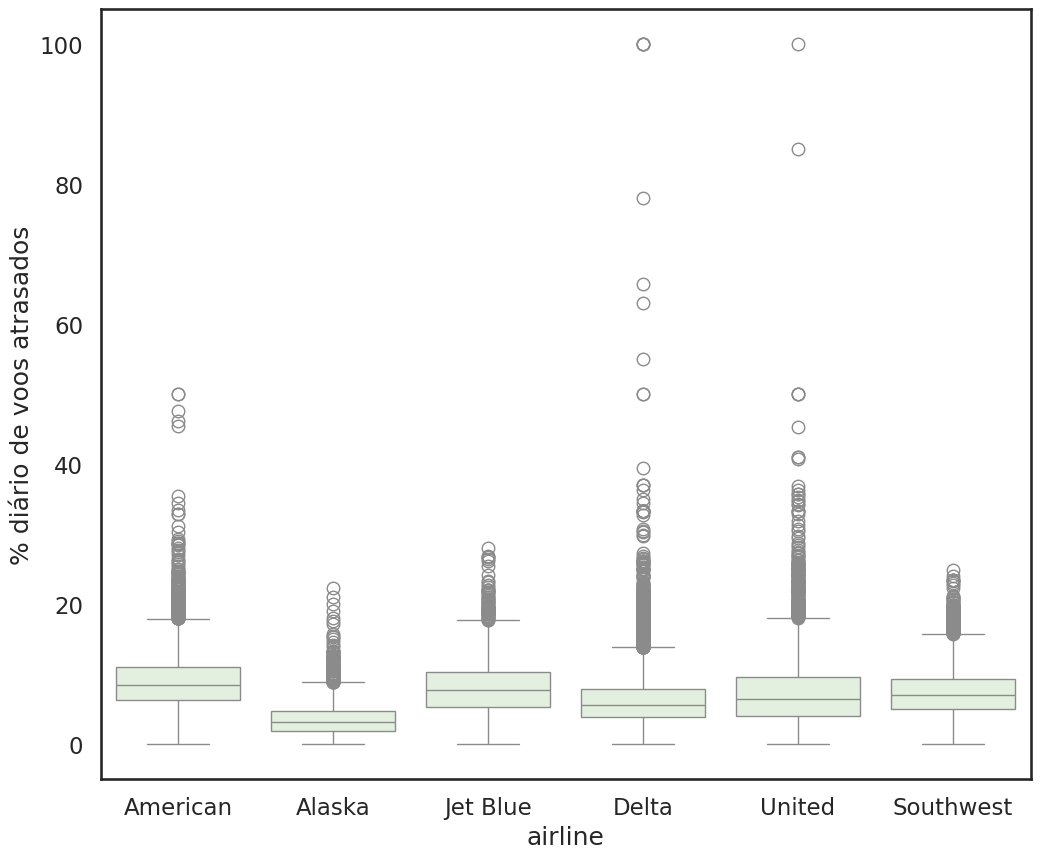

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(x = airline_stats.airline, y = airline_stats.pct_carrier_delay)
plt.ylabel("% diario de vuelos retrasados")
plt.show()

Alaska destaca por tener menos retrasos, mientras que American registra la mayoría.
El cuartil inferior de American es mayor que el cuartil superior de Alaska.


El compartimento hexagonal es una herramienta útil que permite el estudio gráfico de dos variables numéricas simultáneamente, sin verse abrumado por grandes cantidades de datos.
La tabla de contingencia es la herramienta más común para observar los recuentos de dos variables categóricas.
Los diagramas de caja permiten registrar una variable numérica frente a una variable categórica.